# CISB62

## Final Project

### Sex detection

For this final project, I wanted to work with images since I did not do so for the midterm. I decided to try three types of Neural Networks to compare when it comes to sex classification. Today we will be utilizing a basic ANN, a basic CNN, and an Autoencoder type CNN. 

## Imports

- numpy and plt for number manipulation
- pandas for data manipulation
- os and cv2 to read data
- random to allow for shuffling data
- keras and various layers for the models themselves
- np_utils to hot-encode outcomes
- sgd for ANN
- confusion_matrix and itertools for model performance comprehension

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2
import random

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Input, UpSampling2D
from keras.utils import to_categorical
import np_utils
from collections import Counter
import tensorflow as tf

from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

## About dataset

The dataset used for this project can be found at: https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset

This dataset contains around 60,000 images of male and female faces. At that number, it was simply too long to train multiple models to justify, so the dataset was heavily cut down. I am only using 10,000 images in this example, but left about 20,000 in the data files in case one may want to try these models with a bigger dataset. Each category has its own folder which makes separation for the set we use here very easy.

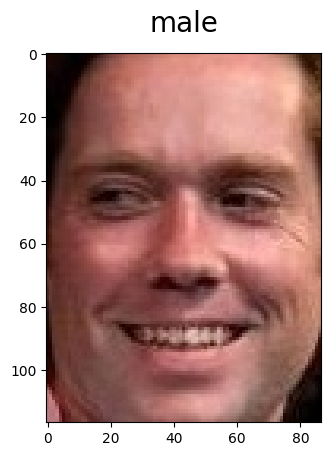

Image shape (Resolution): (117, 87, 3)


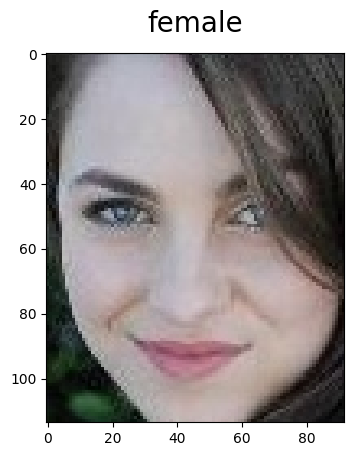

Image shape (Resolution): (114, 92, 3)


In [2]:
data_path = 'archive/data'
categories = ['male', 'female']

for category in categories:
    count = 0
    while count <= 2000:
        path = os.path.join(data_path,category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img))
            
            rgb_img = img_array[...,::-1]
            
            plt.imshow(rgb_img)
            plt.title(category, fontdict = {'fontsize':20}, pad = 15)
            plt.show()
            print(f'Image shape (Resolution): {rgb_img.shape}')
            
            count+=1
            break
        break

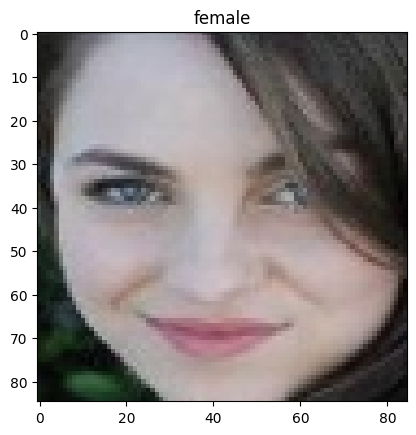

In [3]:
img_size = 85

n_array = cv2.resize(rgb_img, (img_size, img_size))

plt.title(category)
plt.imshow(n_array)
plt.show()

### Sizing Data

I settled on 10,000 as a suitable number of datapoints for this project, and for ease of training, resized every image to an 85 by 85 square, a bit smaller than we have done in some examples, such as the Simpsons, but should help training run a bit quicker, with hopefully minimal impact on results.

In [4]:
training_data = []
n = 5000
def create_training_data():
    for category in categories:
        i = 0
        path = os.path.join(data_path,category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img))
            n_array = cv2.resize(img_array, (img_size, img_size))
            training_data.append([n_array, class_num])
            i+=1
            if i>=n:
                break
            
create_training_data()

In [5]:
len(training_data)

10000

In [6]:
#Shuffling data
random.shuffle(training_data)
for sample in training_data[:10]:
    print(sample[1])

1
1
1
0
1
0
0
0
1
0


In [7]:
#Seperating images and labels for use in training
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, img_size, img_size,3)

In [8]:
print("Pics:", X.shape[0],"Pic resolution:", X.shape[1:3], "Dimension:", X.shape[3])

Pics: 10000 Pic resolution: (85, 85) Dimension: 3


Text(0.5, 1.0, 'male')

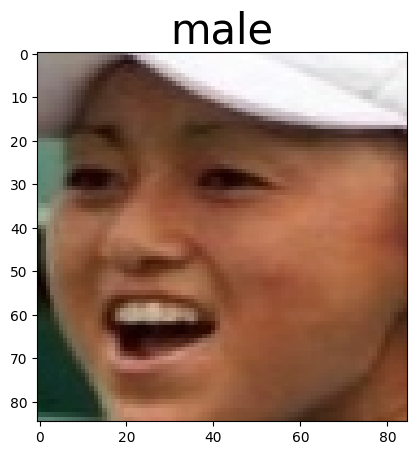

In [9]:
#Random image to check that X and y were transferred correctly
rand_img = X[9000]
plt.imshow(rand_img[...,::-1])
plt.title(categories[y[9000]],fontdict = {'fontsize':30})

## Splitting data

Data is split 80-20 and X is divided by 255 to normalize data. y is then hotcoded to 2 values, being "male" and "female

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2)

In [11]:
X_train_size = len(X_train)
X_test_size = len(X_test)

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

X_train = np.reshape(X_train, (X_train_size, 85,85,3))
X_test = np.reshape(X_test, (X_test_size, 85,85,3))

print(X_train.shape)
print(X_test.shape)

(8000, 85, 85, 3)
(2000, 85, 85, 3)


In [12]:
n_classes = 2
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

# First Model

A simple ANN that uses a few hidden layers with dropout dispersed through them to prevent overfitting to the training dataset. SGD is used on this model because while it is slower, it tends to generalize better and end with a sloution that functions a bit better. The simplicity of this model makes the accuracy provided by SGD a must. The learning rate is tuned up to a 0.10, as this helps with much better results, but it also results in a much more rocky learning curve, as seen below, so a model such as this would need a bit more optimization to find its peak efficiency.

In [13]:
model = Sequential()

model.add(Dense(32, activation='relu',input_shape=(85,85,3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 85, 85, 32)        128       
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 flatten (Flatten)           (None, 231200)            0         
                                                                 
 dense_1 (Dense)             (None, 128)               29593728  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 29594114 (112.89 MB)
Trainable params: 295

In [15]:
model.compile(loss='mean_squared_error',optimizer=SGD(learning_rate=0.1),metrics=['accuracy'])

## Callback

This callback is set to help tune the epochs needed on my models. To prevent overfitting, this callback is called with each model to tell it to stop once it is at 95% Training accuracy. This also helps to disect how the models interact with training versus validation.

In [16]:
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') is not None and logs.get('accuracy') > 0.95: # @KEEP
                print("\nReached 95% accuracy so cancelling training!") 
                
                # Stop training once the above condition is met
                self.model.stop_training = True

In [17]:
callbacks = myCallback()

In [18]:
history = model.fit(X_train,y_train, batch_size = 24, epochs = 10, verbose = 1, validation_data = (X_test, y_test), callbacks = callbacks)

Epoch 1/10
334/334 [==============================] - 32s 94ms/step - loss: 0.4916 - accuracy: 0.5025 - val_loss: 0.2222 - val_accuracy: 0.6925
Epoch 2/10
334/334 [==============================] - 31s 94ms/step - loss: 0.1650 - accuracy: 0.7639 - val_loss: 0.1088 - val_accuracy: 0.8495
Epoch 3/10
334/334 [==============================] - 31s 93ms/step - loss: 0.1031 - accuracy: 0.8619 - val_loss: 0.0908 - val_accuracy: 0.8700
Epoch 4/10
334/334 [==============================] - 31s 93ms/step - loss: 0.0839 - accuracy: 0.8878 - val_loss: 0.2067 - val_accuracy: 0.6945
Epoch 5/10
334/334 [==============================] - 31s 93ms/step - loss: 0.0756 - accuracy: 0.9013 - val_loss: 0.1282 - val_accuracy: 0.8350
Epoch 6/10
334/334 [==============================] - 31s 93ms/step - loss: 0.0667 - accuracy: 0.9124 - val_loss: 0.0664 - val_accuracy: 0.9085
Epoch 7/10
334/334 [==============================] - 31s 93ms/step - loss: 0.0607 - accuracy: 0.9197 - val_loss: 0.0854 - val_accuracy:

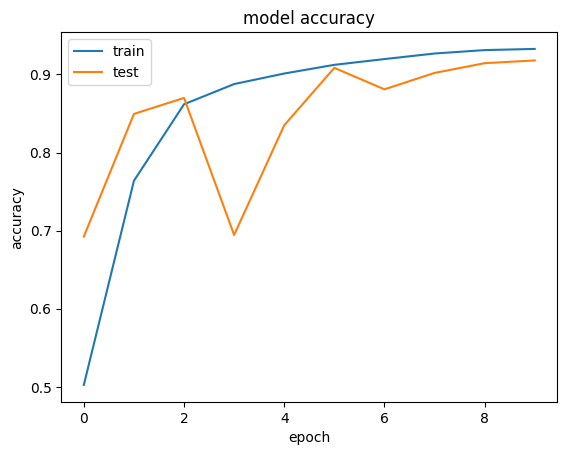

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
def plot_confusion_matrix(cm, classes, normalize = False, title='Confusion matrix', cmap = plt.cm.Reds):
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title,fontdict = {'fontsize':30})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontdict = {'fontsize':12}, ha='right')
    plt.yticks(tick_marks, classes,fontdict = {'fontsize':12})
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('Observation', fontdict = {'fontsize': 25})
    plt.xlabel('Prediction', fontdict = {'fontsize': 25})

63/63 [==============================] - 1s 19ms/step


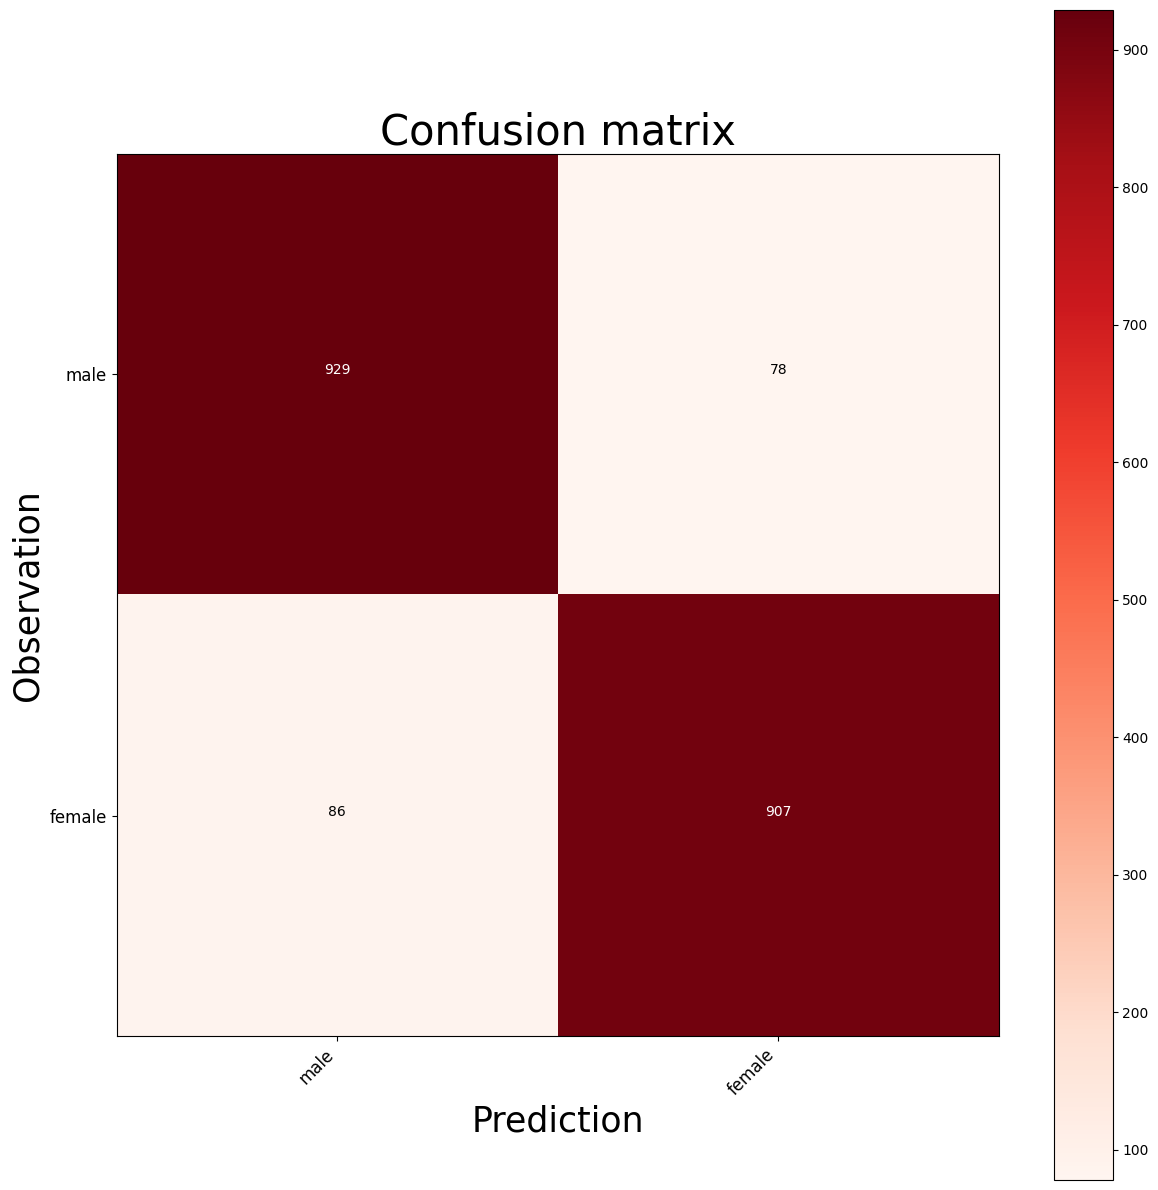

In [21]:
ann_Y_pred = model.predict(X_test)

ann_Y_pred_classes = np.argmax(ann_Y_pred, axis=1)

ann_Y_true = np.argmax(y_test, axis=1)

ann_confusion_matrix = confusion_matrix(ann_Y_true, ann_Y_pred_classes)
plot_confusion_matrix(ann_confusion_matrix,classes=categories)

# Second Model

The second model is a basic CNN. We go through the MaxPooling shrinkage 3 times to reduce dimensionality all the way down to an 8 by 8 input, then we feed that from the CNN portion to the Fully-connected layers to make our decision. This model fits to the training data very quickly, but begins to overfit quite fast, so stopping on an early epoch with the model as it stands is near mandatory. Throughout the many times I have run through the training process for this model, it seems to always top out around the second or third epoch, and slowly fall after that. 

In [22]:
model_1 = Sequential()

model_1.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(85, 85, 3)))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(BatchNormalization())

model_1.add(Conv2D(filters=64, activation='relu', kernel_size=3))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(BatchNormalization())

model_1.add(Conv2D(filters=64, activation='relu', kernel_size=3))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(BatchNormalization())
model_1.add(Flatten())
model_1.add(Dense(128, activation="relu"))
model_1.add(Dense(128, activation="relu"))
model_1.add(Dense(2, activation='softmax'))  


model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [23]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 83, 83, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 41, 41, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 41, 41, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 39, 39, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 19, 19, 64)        0         
 g2D)                                                            
                                                      

In [24]:
# Fit the model
history_1 = model_1.fit(X_train,y_train, batch_size = 24, epochs = 10, verbose = 1, validation_data = (X_test, y_test), callbacks = callbacks)

Epoch 1/10
334/334 [==============================] - 37s 107ms/step - loss: 0.2813 - accuracy: 0.8846 - val_loss: 0.9394 - val_accuracy: 0.5455
Epoch 2/10
334/334 [==============================] - 35s 106ms/step - loss: 0.1699 - accuracy: 0.9365 - val_loss: 0.1721 - val_accuracy: 0.9360
Epoch 3/10
333/334 [============================>.] - ETA: 0s - loss: 0.1213 - accuracy: 0.9543
Reached 95% accuracy so cancelling training!
334/334 [==============================] - 36s 106ms/step - loss: 0.1216 - accuracy: 0.9542 - val_loss: 0.2571 - val_accuracy: 0.9115


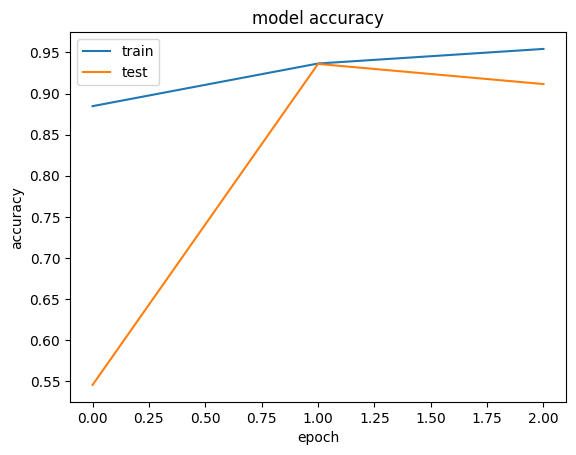

In [25]:
import matplotlib.pyplot as plt

plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

63/63 [==============================] - 2s 30ms/step


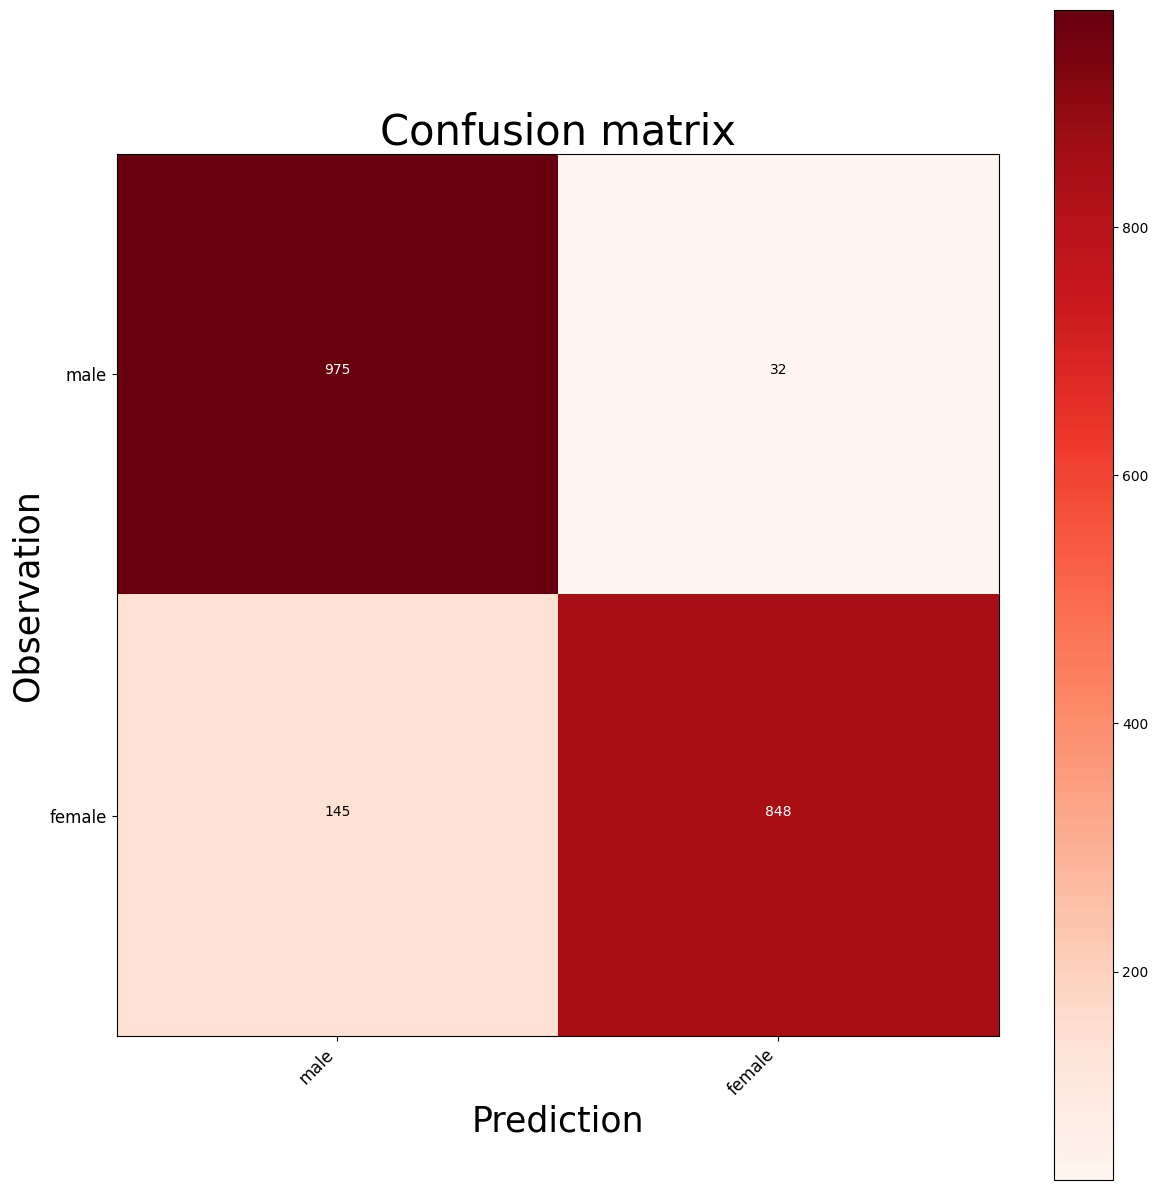

In [26]:
cnn_Y_pred = model_1.predict(X_test)

cnn_Y_pred_classes = np.argmax(cnn_Y_pred, axis=1)

cnn_Y_true = np.argmax(y_test, axis=1)

cnn_confusion_matrix = confusion_matrix(cnn_Y_true, cnn_Y_pred_classes)
plot_confusion_matrix(cnn_confusion_matrix,classes=categories)

# Third Model

The third model is a CNN built as an autoencoder to help pick out datapoints and a deeper understanding of the data than would otherwise be available. The Encoder reduces dimensionality 3 times to create a bottleneck, and hands that data off to the Decoder. I decided that the decoder should increase dimensionality only twice. This still gives the network a chance to make its own decisions on what datapoints are important to fill in the gaps, but helps training a little less computationally expensive because it is not blown up to its original size. The data is then flattened, and ran through a couple fully connected layers to make its final decisions. This model generally had the best results in testing. 

In [27]:
model_2 = Sequential()

#Encoder
model_2.add(Dense(32, activation='relu',input_shape=(85,85,3)))
model_2.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D((2, 2), padding='same'))

model_2.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D((2, 2), padding='same'))

model_2.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model_2.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model_2.add(UpSampling2D((2, 2)))

model_2.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model_2.add(UpSampling2D((2, 2)))
model_2.add(Flatten())

model_2.add(Dense(256, activation="relu"))
model_2.add(Dense(128, activation="relu"))
model_2.add(Dense(2, activation='softmax'))

In [28]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics ='accuracy')

In [29]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 85, 85, 32)        128       
                                                                 
 conv2d_3 (Conv2D)           (None, 85, 85, 16)        4624      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 43, 43, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 43, 43, 8)         1160      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 22, 22, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 8)        

In [30]:
# Fit the model
history_2 = model_2.fit(X_train,y_train, batch_size = 24, epochs = 10, verbose = 1, validation_data = (X_test, y_test), callbacks = callbacks)

Epoch 1/10
334/334 [==============================] - 38s 111ms/step - loss: 0.4315 - accuracy: 0.7925 - val_loss: 0.2851 - val_accuracy: 0.8820
Epoch 2/10
334/334 [==============================] - 36s 108ms/step - loss: 0.2395 - accuracy: 0.9056 - val_loss: 0.3230 - val_accuracy: 0.8820
Epoch 3/10
334/334 [==============================] - 36s 108ms/step - loss: 0.1960 - accuracy: 0.9237 - val_loss: 0.1923 - val_accuracy: 0.9200
Epoch 4/10
334/334 [==============================] - 36s 108ms/step - loss: 0.1614 - accuracy: 0.9360 - val_loss: 0.2013 - val_accuracy: 0.9190
Epoch 5/10
334/334 [==============================] - 36s 108ms/step - loss: 0.1379 - accuracy: 0.9466 - val_loss: 0.1997 - val_accuracy: 0.9195
Epoch 6/10
334/334 [==============================] - ETA: 0s - loss: 0.1193 - accuracy: 0.9531
Reached 95% accuracy so cancelling training!
334/334 [==============================] - 36s 107ms/step - loss: 0.1193 - accuracy: 0.9531 - val_loss: 0.2069 - val_accuracy: 0.9245


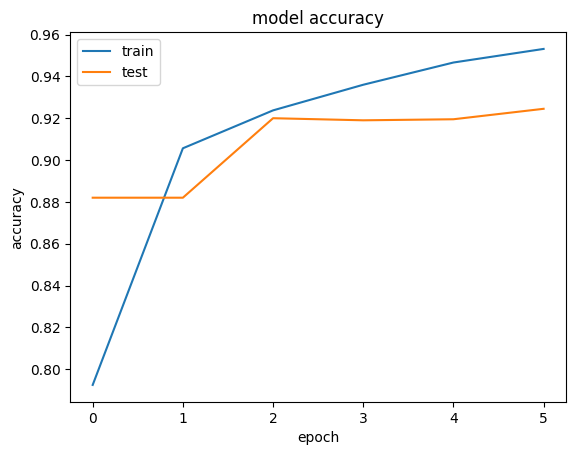

In [31]:
import matplotlib.pyplot as plt

plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

63/63 [==============================] - 2s 24ms/step


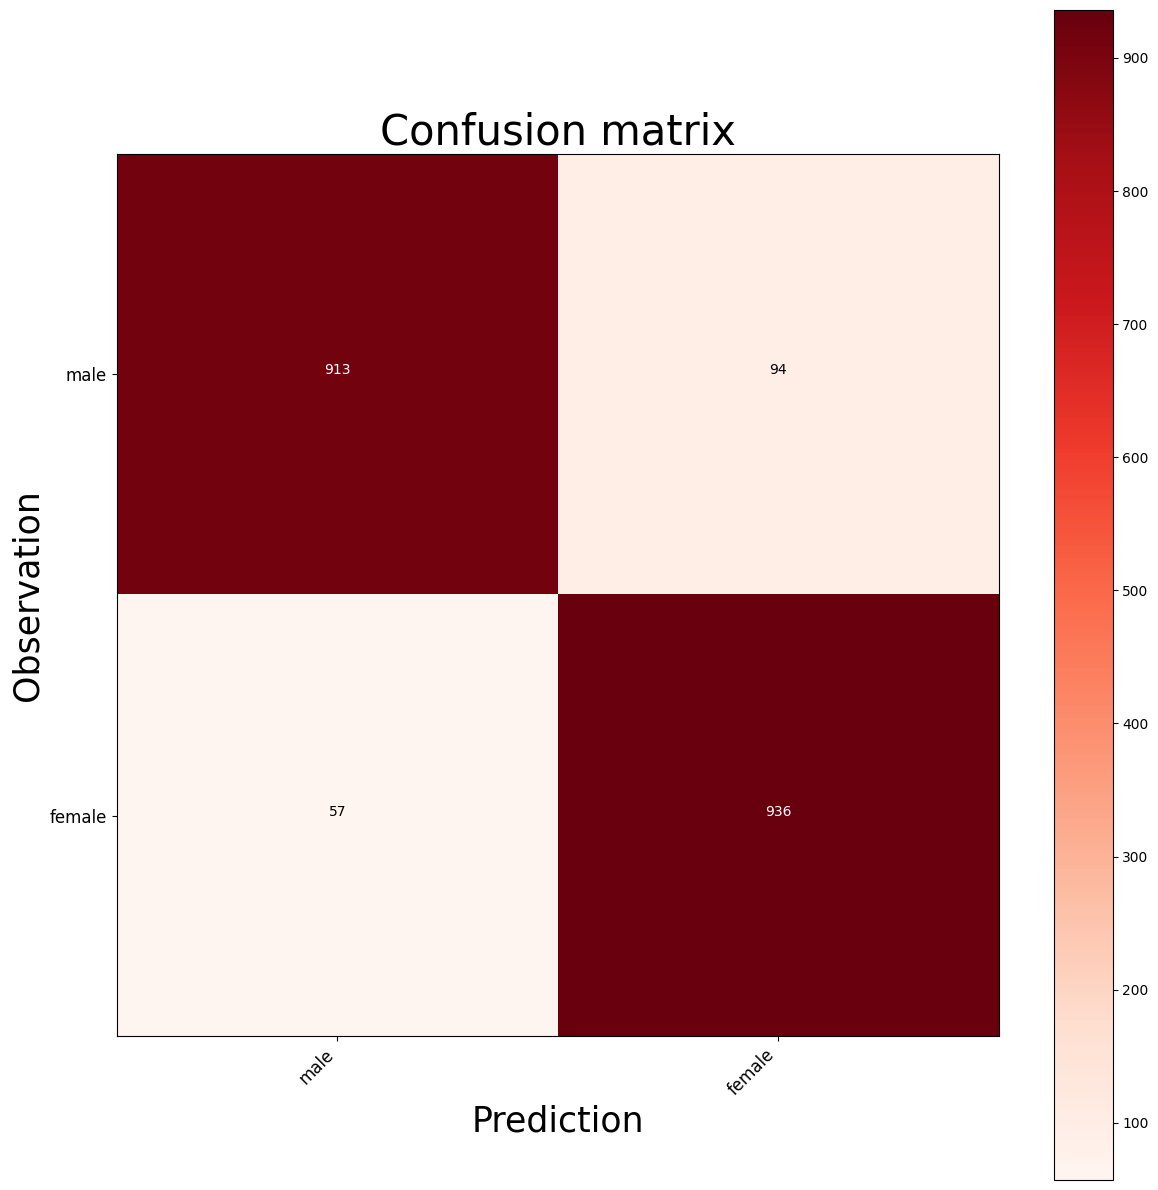

In [32]:
ae_Y_pred = model_2.predict(X_test)

ae_Y_pred_classes = np.argmax(ae_Y_pred, axis=1)

ae_Y_true = np.argmax(y_test, axis=1)

ae_confusion_matrix = confusion_matrix(ae_Y_true, ae_Y_pred_classes)
plot_confusion_matrix(ae_confusion_matrix,classes=categories)

# Conclusion

In my testing, there is a clear deliniation between types of models. The ANN performed the worst, but requires very little computationally compared to the following models, as well as requiring much fewer lines of code, which could allow for much more time hyper-focusing on optimization. The basic CNN learned important features extremely quickly, but would also overfit very fast, leading to a very low-epoch training session. The auto-encoder performed very well very consistentely. It took longer to learn features than the basic CNN, but seemed much more resisting to overfitting, leading to a better learning curve that could probably be trained longer for a more successful algorithm without a massive risk for overfitting.